In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

import matplotlib
from matplotlib.ticker import MultipleLocator

In [2]:
print('NumPy version: {}'.format(np.__version__))
print('pandas version: {}'.format(pd.__version__))
print('matplotlib version: {}'.format(matplotlib.__version__))

NumPy version: 1.15.4
pandas version: 1.1.0
matplotlib version: 3.0.1


In [3]:
%matplotlib notebook

In [4]:
# SN metadata

z = 0.0307
t_max = 2458986.91
t_max_mjd = t_max - 2400000.5

In [5]:
def plot_box_spec(wave, flux): 
    flux_plot = np.repeat(flux, 2)
    wv_plot = wave.copy()
    wv_plot[:-1] += np.diff(wave)/2
    wv_plot = np.append(wave[0]-(wave[1]-wave[0])/2, 
                        np.append(np.repeat(wv_plot[0:-1], 2), 
                                  wave[-1]+(wave[-1]-wave[-2])/2))
    
    return wv_plot, flux_plot

In [6]:
spec_files = glob.glob('../data/spectroscopy/*ascii')
spec_files.sort()

In [7]:
spec_files

['../data/spectroscopy/ZTF20aayhacx_20200507_P60_v2.ascii',
 '../data/spectroscopy/ZTF20aayhacx_20200513_NOT_v3.ascii',
 '../data/spectroscopy/ZTF20aayhacx_20200521_P60_v2.ascii',
 '../data/spectroscopy/ZTF20aayhacx_20200528_P60_v2.ascii',
 '../data/spectroscopy/ZTF20aayhacx_20200529_Lick_3-m_v1.ascii',
 '../data/spectroscopy/ZTF20aayhacx_20200531_P60_v1.ascii',
 '../data/spectroscopy/ZTF20aayhacx_20200608_P60_v2.ascii',
 '../data/spectroscopy/ZTF20aayhacx_20200610_P200_v2.ascii',
 '../data/spectroscopy/ZTF20aayhacx_20200623_Keck1_v1.ascii']

<IPython.core.display.Javascript object>


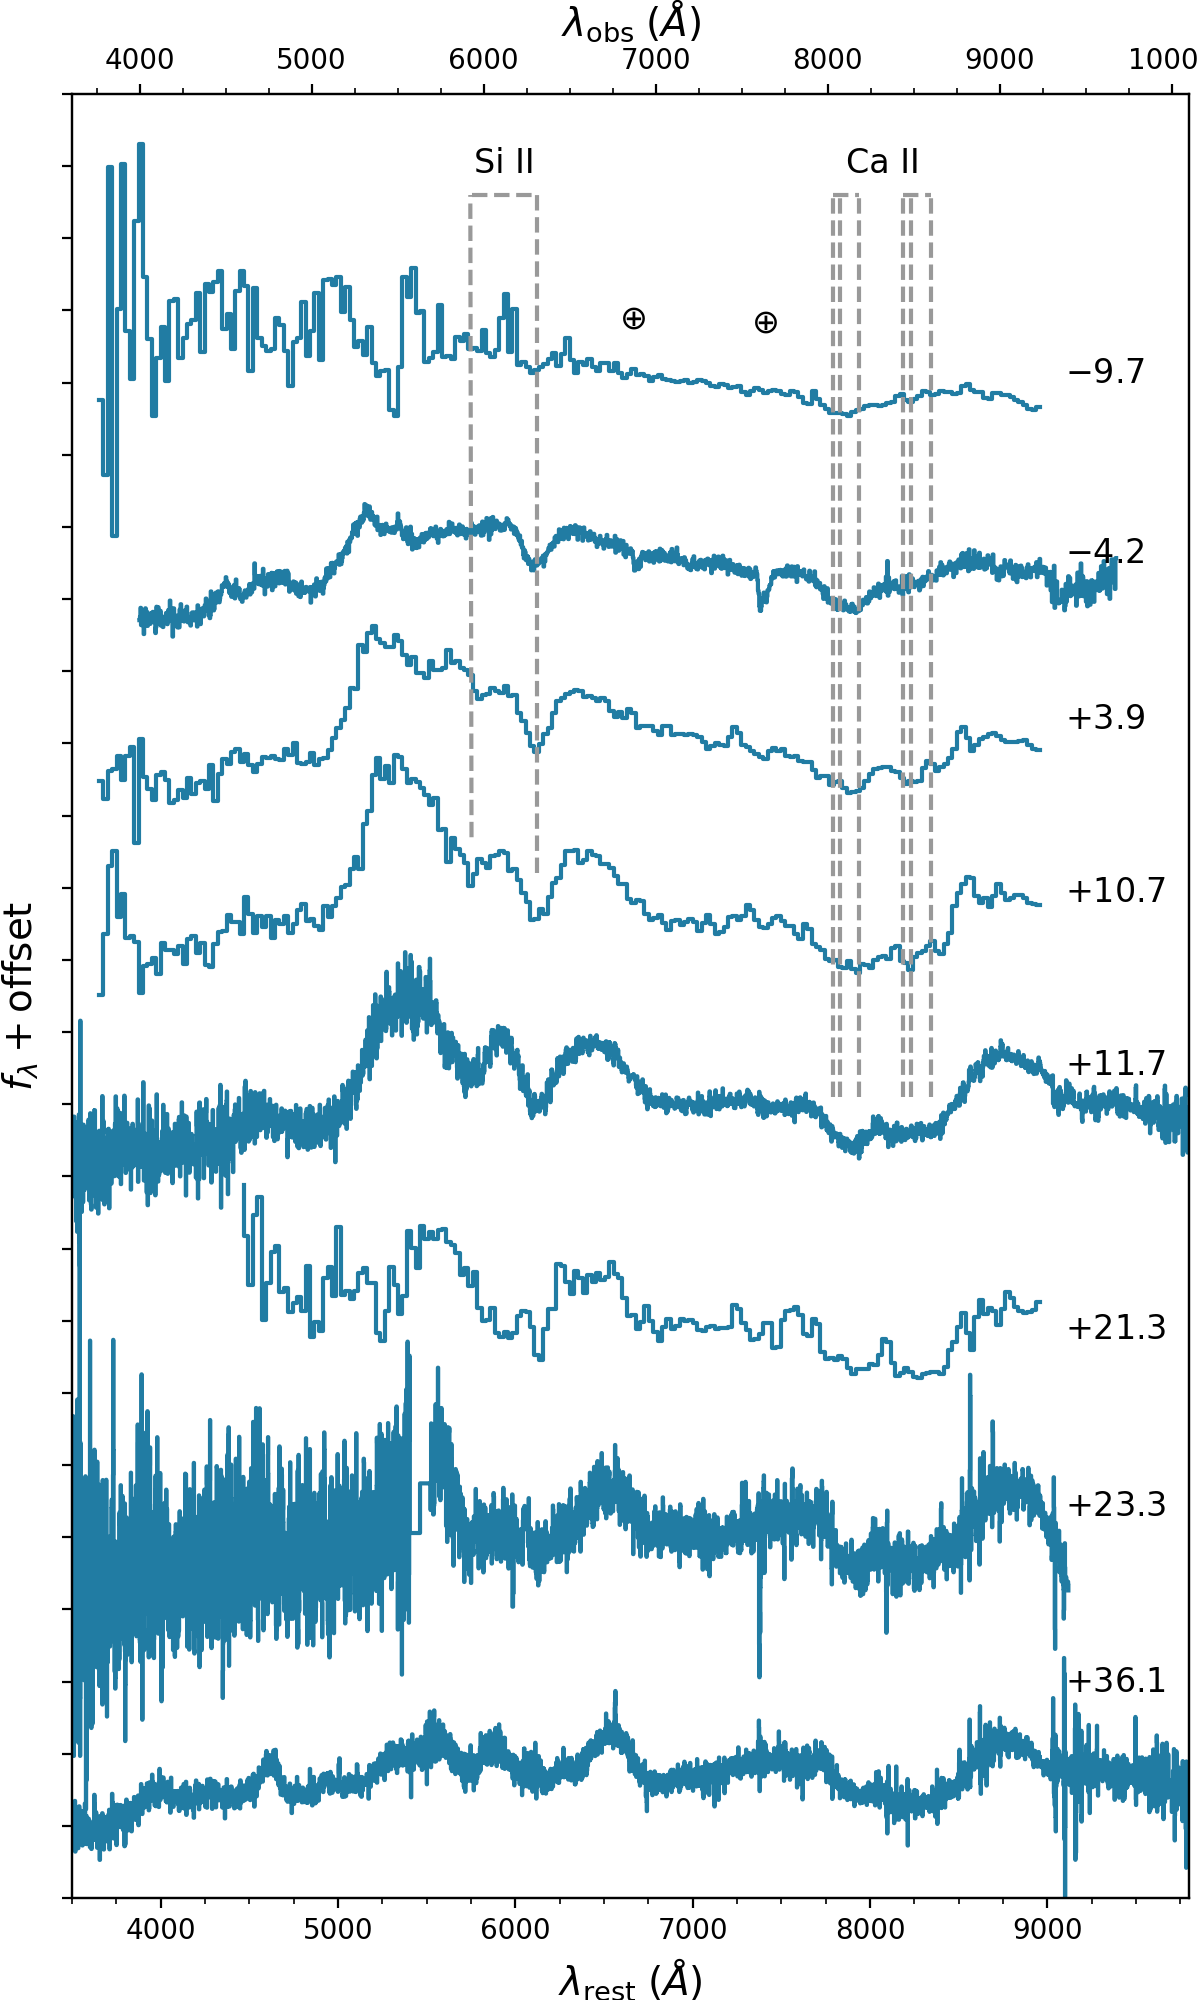

In [8]:
aam_colors = {'mustard': "#E29930",
             'blue': "#217CA3",
             'asphalt': "#32384D",
             'navy': "#444C5C",
             'punch': "#CE5A57",
             'ocean': "#78A5A3",
             'warm': "#E1B16A",}

phase_list = []
mjd_list = []

fig, ax = plt.subplots(figsize=(6,10))

for spec_num, spec in enumerate(spec_files):
    spec_df = pd.read_csv(spec, comment='#', delim_whitespace=True, header=None)
    
    wv, fl = plot_box_spec(spec_df[0].values, spec_df[1].values)
    
    norm_flux = np.median(fl[np.where((wv > 7200) & (wv < 7400))])
#     if not np.isfinite(norm_flux):
#         norm_flux = 400
    if spec_num == 5:
        continue
#         show_red = np.where((wv > 4600))
#         ax.plot(wv[show_red]/(1+z), fl[show_red]/norm_flux - 3*spec_num, color=aam_colors['blue'])
    elif spec_num == 6:
        show_red = np.where((wv > 4600))
        ax.plot(wv[show_red]/(1+z), fl[show_red]/norm_flux - 2.5*(spec_num-1) - 0.6, color=aam_colors['blue'])
    elif spec_num == 7:
        show_blue = np.where((wv < 9400))
        ax.plot(wv[show_blue]/(1+z), fl[show_blue]/norm_flux - 2.5*(spec_num-1) - 1, color=aam_colors['blue'])
    elif spec_num == 8:
        ax.plot(wv/(1+z), fl/norm_flux - 2.5*(spec_num-1) - 1.8, color=aam_colors['blue'])
    else:
        ax.plot(wv/(1+z), fl/norm_flux - 2.5*spec_num, color=aam_colors['blue'])
    
    with open(spec) as f:
        ll = f.readlines()
    # brute force
    for l in ll:
        if 'MJD' in l:
            if '=' in l and 'at start' in l:
                mjd_obs = float(l.split('=')[1].split("'")[1])
            elif '=' in l and '/' in l:
                mjd_obs = float(l.split('=')[1].split('/')[0])
            elif '=' in l:
                mjd_obs = float(l.split('=')[1])
            elif ':' in l:
                mjd_obs = float(l.split(':')[1])
            break
    
    phase = (mjd_obs - t_max_mjd)/(1+z)
    phase_list.append(phase)
    mjd_list.append(mjd_obs)
    if mjd_obs < t_max_mjd:
        ax.text(9100, 1- 2.5*spec_num, r'$-{:.1f}$'.format(np.abs(phase)), fontsize=12)
    elif mjd_obs - t_max_mjd > 13:
        ax.text(9100, 0 - 2.45*(spec_num-1), r'$+{:.1f}$'.format(np.abs(phase)), fontsize=12)
    else:
        ax.text(9100, 1- 2.4*spec_num, r'$+{:.1f}$'.format(np.abs(phase)), fontsize=12)
    
ax.set_xlim(3500,9800)
ax.set_ylim(-20.,5)
ax.set_yticklabels([])
ax.set_ylabel(r'$f_\lambda + \mathrm{offset}$', fontsize=14)
ax.set_xlabel(r'$\lambda_\mathrm{rest} \;  (\AA)$', fontsize=14)
ax.xaxis.set_minor_locator(MultipleLocator(250))
ax.yaxis.set_major_locator(MultipleLocator(1))

wv_obs = ax.twiny()
wv_obs.set_xlim(np.array(ax.get_xlim())*(1+z))
wv_obs.set_xlabel(r'$\lambda_\mathrm{obs} \; (\AA)$', fontsize=14)
wv_obs.xaxis.set_minor_locator(MultipleLocator(250))

# plot lines
# Si II 6355
ax.plot([6355*(1-11000/2.9979e5), 6355*(1-11000/2.9979e5)], 
        [-5.8,3.6], '--', color='0.6')
# Si II 5972
ax.plot([5972*(1-11000/2.9979e5), 5965*(1-11000/2.9979e5)], 
        [-5.3,3.6], '--', color='0.6')
# # Si II 5669
# ax.plot([5669*(1-19000/2.9979e5), *5670*(1-18000/2.9979e5)], 
#         [-1.5,3.6], '--', color='0.6')
# # Si II 5047
# ax.plot([5047*(1-19000/2.9979e5), *5047*(1-18000/2.9979e5)], 
#         [-1.6,3.6], '--', color='0.6')
ax.plot([5972*(1-11000/2.9979e5), 6355*(1-11000/2.9979e5)], 
        [3.6,3.6], '--', color='0.6')
ax.text(5937.346, 3.9, 
        r'Si II', ha='center', fontsize=12)



# Ca II 8498 - HV
ax.plot([8498*(1-25000/2.9979e5), 8498*(1-25000/2.9979e5)], 
        [-8.9,3.6], '--', color='0.6')
# Ca II 8542 - HV
ax.plot([8542*(1-25000/2.9979e5), 8542*(1-25000/2.9979e5)], 
        [-8.9,3.6], '--', color='0.6')
# Ca II 8662 - HV
ax.plot([8662*(1-25000/2.9979e5), 8662*(1-25000/2.9979e5)], 
        [-8.9,3.6], '--', color='0.6')
ax.plot([8498*(1-25000/2.9979e5), 8662*(1-25000/2.9979e5)], 
        [3.6,3.6], '--', color='0.6')


# Ca II 8498
ax.plot([8498*(1-11000/2.9979e5), 8498*(1-11000/2.9979e5)], 
        [-8.9,3.6], '--', color='0.6')
# Ca II 8542
ax.plot([8542*(1-11000/2.9979e5), 8542*(1-11000/2.9979e5)], 
        [-8.9,3.6], '--', color='0.6')
# Ca II 8662
ax.plot([8662*(1-11000/2.9979e5), 8662*(1-11000/2.9979e5)], 
        [-8.9,3.6], '--', color='0.6')
ax.plot([8498*(1-11000/2.9979e5), 8662*(1-11000/2.9979e5)], 
        [3.6,3.6], '--', color='0.6')
ax.text(8070, 3.9, 
        r'Ca II', ha='center', fontsize=12)


ax.text(7633/(1+z), 1.7, r'$\oplus$', 
        ha='center', fontsize=12)
ax.text(6867/(1+z), 1.75, r'$\oplus$', 
        ha='center', fontsize=12)


fig.subplots_adjust(left=0.06,bottom=0.051,top=0.953,right=0.991)
fig.savefig('../paper/figures/optical_spec_evolution.pdf')

In [9]:
with open('../playground/spec_phase.txt', 'w') as fw:
    print('specname phase mjd', file=fw)
    for sfile, p, m in zip(spec_files, phase_list, mjd_list):
        print(sfile.split('/')[-1], p, m, file=fw)